<a href="https://colab.research.google.com/github/LMelisaGaviria/Monografia_Elasticidad_PrecioDemanda/blob/main/Monografia_Proyecto_Dominicks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Estudiante: Laura Melisa Gaviria Tapias

CC: 1035232148

El presente trabajo de monografía tiene como objetivo analizar la elasticidad precio de la demanda de productos de papel higiénico (Bathroom Tissue) utilizando el conjunto de datos Dominicks-Manual-and-Codebook_KiltsCenter. Este dataset, proporcionado por el Kilts Center for Marketing de la Universidad de Chicago, contiene información real detallada sobre precios, volúmenes de venta y características de productos comercializados en la cadena de supermercados Dominick's.

Este notebook documenta el proceso completo del análisis, incluyendo la preparación y limpieza de los datos, la exploración inicial, 4 modelos de machine learning(Arboles de decisión, Random Forest, Moment T5,  feed-forward neural network) para predecir y analizar la elasticidad del precio basado en las promociones aplicadas, resultados y conclusiones. El objetivo es contribuir al entendimiento de las dinámicas de mercado de bienes de consumo masivo, para luego proponer su implementación en empresas del mercado Colombiano.

El dataset cuenta con 2 conjuntos de datos:
1. UPC (Universal product code) corresponde datos de información de los productos, códigos, descripción, tamaño.
2. Archivo de movimientos, contiene data de ventas semanales por UPC, de 5 años, precios, promociones, margen de ganancia, tienda, otros.

**Variable Description Type Length**

**upc**: universal Product code numérico 8

**store**: número de tienda numérico  3

**week**: número de semana numérico  3

**move**: Cantidad vendida numérico  8

**price**: Precio retail numérico  8

**qty**: Número de articulos juntos numérico  3

**profit**: Margen de ganancia numérico  8

**sale**: código de promoción (B(Bono),C(Cupón),S(reducción simple de precio)) Character 8

**ok**: 1 para datos validos, 0 datos sospechosos numérico  

##Librerias

In [98]:
#Librerias...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
#Acá montamos el Drive para poder leer los datasets desde
#la carpeta de drive y no tener que subir los archivos cada que se vaya a ejecutar el código
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [100]:
#Leemos las rutas de los 2 datasets que están en formato CSV a utilizar y creamos los dataframes
#Llamamos df_master al dataframe que contiene los datos maestros: código de referencia, descripción de referencia
ruta_master = "/content/drive/MyDrive/Universidad/Especialización Analítica/Monografia/Proyecto_dominicks/upctti.csv"
ruta_move = "/content/drive/MyDrive/Universidad/Especialización Analítica/Monografia/Proyecto_dominicks/wtti.csv"

df_master = pd.read_csv(ruta_master)
df_move = pd.read_csv(ruta_move)

##Exploración de los dataset

In [101]:
#Miramos las dimensiones de los dataset que tenemos
sf_master = df_master.shape
sf_move = df_move.shape

print(sf_master)
print(sf_move)

(128, 6)
(1627284, 11)


El dataset de master tiene 128 filas, lo que quiere decir que se cuenta con 128 referencias y 6 columnas que describen las referencias.
El dataset de movimientos, donde están registradas las ventas, precios, descuentos y demás datos de interés para los modelos tiene 11 columnas y 1'627.284 filas.

###**Exploración dataset master**

In [102]:
#Exploración de los datos del archivo master
print("Primeras filas de df_master:")
print(df_master.head())

Primeras filas de df_master:
   COM_CODE         UPC               DESCRIP   SIZE  CASE    NITEM
0       552  1122542346  VT BATH TISSUE 2 PLY   8 CT    12  1103571
1       552  3040000048  ANGEL SFT BTH TISSUE   4 CT    24  1103311
2       552  3040000069     ANGEL SOFT PASTEL   6 CT    16  1103331
3       552  3040000087  ANGEL SOFT WHITE BAT  12 CT     8  1103301
4       552  3040000104  ANGEL SOFT KIDS PRIN   4 CT    24  1103321


Convertimos todas los textos de ambos dataset que contengan mayúsculas a minúsculas para evitar problemas en el código y facilitar la exploración.

In [103]:
df_master.columns = df_master.columns.str.lower()
print("Nombres de las columnas de df_master en minúsculas:")
print(df_master.columns)
df_move.columns = df_move.columns.str.lower()
print("\nNombres de las columnas de df_move en minúsculas:")
print(df_move.columns)

Nombres de las columnas de df_master en minúsculas:
Index(['com_code', 'upc', 'descrip', 'size', 'case', 'nitem'], dtype='object')

Nombres de las columnas de df_move en minúsculas:
Index(['store', 'upc', 'week', 'move', 'price', 'qty', 'sale', 'profit', 'ok',
       'price_hex', 'profit_hex'],
      dtype='object')


In [104]:
print("\nInformación de df_master:")
df_master.info()


Información de df_master:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   com_code  128 non-null    int64 
 1   upc       128 non-null    int64 
 2   descrip   128 non-null    object
 3   size      128 non-null    object
 4   case      128 non-null    int64 
 5   nitem     128 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 6.1+ KB


In [105]:
print("\nAlgunos valores únicos en la columna 'descrip' de df_master:")
print(df_master['descrip'].unique()[:20]) # Muestra los primeros 20 valores únicos
print(f"\nNúmero total de descripciones únicas: {df_master['descrip'].nunique()}")


Algunos valores únicos en la columna 'descrip' de df_master:
['VT BATH TISSUE 2 PLY' 'ANGEL SFT BTH TISSUE' 'ANGEL SOFT PASTEL'
 'ANGEL SOFT WHITE BAT' 'ANGEL SOFT KIDS PRIN' 'ANGEL SOFT BUNDLE PA'
 '~CORONET KING' 'CORONET BATH TISSUE' 'CORONET BATH TISSUES'
 'KLEENEX PP1.09' 'DELSEY ASSORT TOILET' 'KLEENEX COTTONELLE U'
 'KLEENEX ULTRA DBL 12' 'KLEENEX BATH WHITE' 'KLNX TRL SHPR DBL RO'
 'KLEENEX/CNTL 4DBL RL' 'KLEENEX BATH PRINTS' '~KLEENEX DBL ROLL AS'
 'KLEENEX DBL 4-ROLL P' 'KLEENEX DBL ROLL FRE']

Número total de descripciones únicas: 110


###**Exploración dataset de movimientos**

Exploramos las variables que se tienen en el dataset de movimientos, ya que el master, como corresponde a información de identificación no se realiza estadísticas descriptivas.

In [106]:
print("\nColumnas de df_move:")
print(df_move.columns)


Columnas de df_move:
Index(['store', 'upc', 'week', 'move', 'price', 'qty', 'sale', 'profit', 'ok',
       'price_hex', 'profit_hex'],
      dtype='object')


In [107]:
print("\nInformación de df_move:")
df_move.info()


Información de df_move:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1627284 entries, 0 to 1627283
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   store       1627284 non-null  int64  
 1   upc         1627284 non-null  int64  
 2   week        1627284 non-null  int64  
 3   move        1627284 non-null  int64  
 4   price       1627284 non-null  float64
 5   qty         1627284 non-null  int64  
 6   sale        230827 non-null   object 
 7   profit      1627284 non-null  float64
 8   ok          1627284 non-null  int64  
 9   price_hex   1627284 non-null  object 
 10  profit_hex  1627284 non-null  object 
dtypes: float64(2), int64(6), object(3)
memory usage: 136.6+ MB


In [108]:
descripcion = df_move.describe()
descripcion_formateada = descripcion.applymap('{:.2f}'.format)

print("\nEstadísticas descriptivas de df_move (con 2 decimales):")
print(descripcion_formateada)


Estadísticas descriptivas de df_move (con 2 decimales):
            store            upc        week        move       price  \
count  1627284.00     1627284.00  1627284.00  1627284.00  1627284.00   
mean        83.26  4538731920.78      220.22       53.83        1.50   
std         36.63  1120966202.87      114.21      250.49        1.82   
min          2.00  1122542346.00        1.00        0.00        0.00   
25%         56.00  3700060501.00      127.00        0.00        0.00   
50%         89.00  4200013000.00      226.00       15.00        1.09   
75%        113.00  5400046550.00      323.00       44.00        2.09   
max        146.00  7572536485.00      399.00    69394.00      838.16   

              qty      profit          ok  
count  1627284.00  1627284.00  1627284.00  
mean         1.02       11.85        0.98  
std          0.26       12.05        0.13  
min          1.00      -99.88        0.00  
25%          1.00        0.00        1.00  
50%          1.00       11.09 

<ipython-input-108-f289423c88ca>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  descripcion_formateada = descripcion.applymap('{:.2f}'.format)


Aunque algunas variables figuran como enteros, se refieren a variables de texto, como la upc, store, week. Por lo que estas variables se deben convertir a tipo string.

In [109]:
print(f"\nNúmero total de tiendas: {df_move['store'].nunique()}")


Número total de tiendas: 93


In [110]:
print("\nDistribución de las primeras semanas en df_move:")
print(df_move['week'].value_counts().head())
print(f"\nNúmero total de semanas: {df_move['week'].nunique()}")


Distribución de las primeras semanas en df_move:
week
370    6491
371    6491
368    6487
369    6487
366    6487
Name: count, dtype: int64

Número total de semanas: 385


In [111]:
# Unir los DataFrames utilizando la columna 'upc'
df_merged = pd.merge(df_move, df_master, on='upc', how='inner')

print("Dimensiones del DataFrame unido (df_merged):", df_merged.shape)
print("\nPrimeras filas del DataFrame unido:")
print(df_merged.head())

Dimensiones del DataFrame unido (df_merged): (1627284, 16)

Primeras filas del DataFrame unido:
   store         upc  week  move  price  qty sale  profit  ok  \
0      2  1122542346   336     0   0.00    1  NaN     0.0   1   
1      2  1122542346   337     0   0.00    1  NaN     0.0   1   
2      2  1122542346   338     1   2.09    1  NaN    13.3   1   
3      2  1122542346   339     4   2.09    1  NaN    13.3   1   
4      2  1122542346   340     7   2.09    1  NaN    13.3   1   

          price_hex        profit_hex  com_code               descrip  size  \
0  0000000000000000  0000000000000000       552  VT BATH TISSUE 2 PLY  8 CT   
1  0000000000000000  0000000000000000       552  VT BATH TISSUE 2 PLY  8 CT   
2  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
3  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   
4  4000B851EB851EB8  402A99999999999A       552  VT BATH TISSUE 2 PLY  8 CT   

   case    nitem  
0    12  1103571  


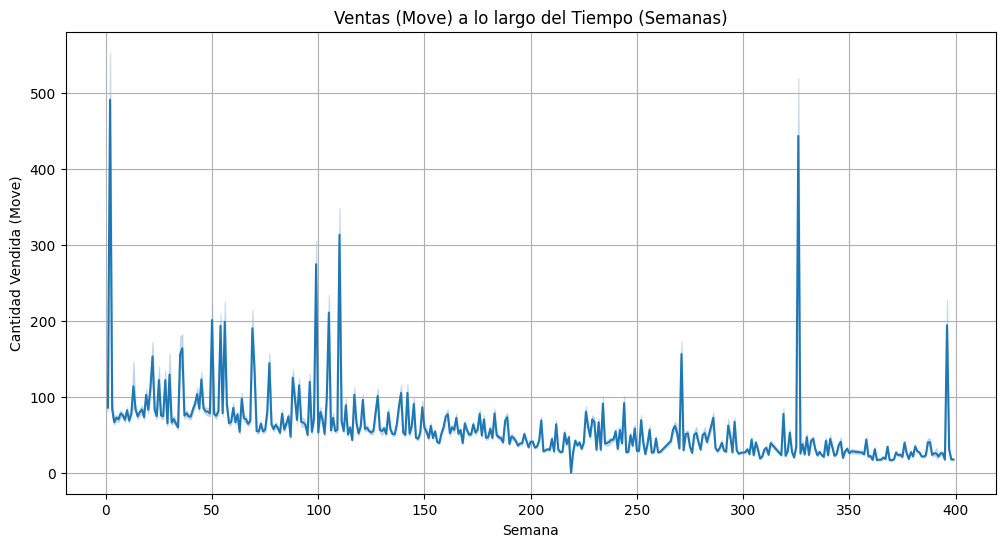

In [112]:
# move en y vs week en x
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='move', data=df_move)
plt.title('Ventas (Move) a lo largo del Tiempo (Semanas)')
plt.xlabel('Semana')
plt.ylabel('Cantidad Vendida (Move)')
plt.grid(True)
plt.show()



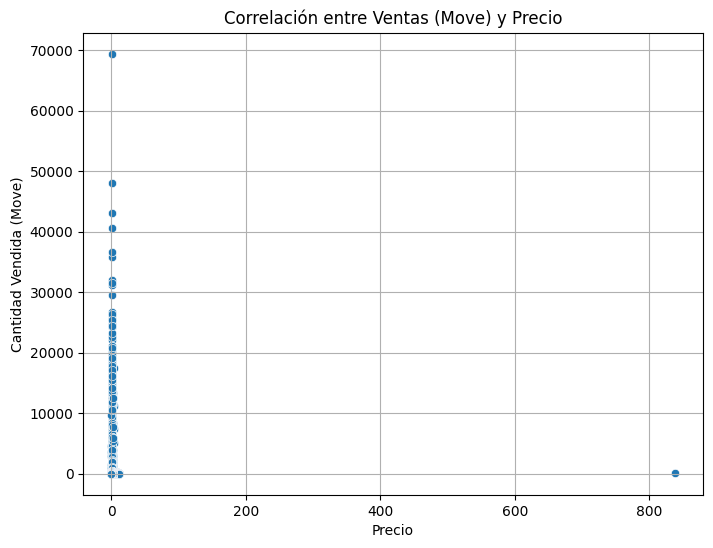

In [113]:

# move vs price para ver su correlación
plt.figure(figsize=(8, 6))
sns.scatterplot(x='price', y='move', data=df_move)
plt.title('Correlación entre Ventas (Move) y Precio')
plt.xlabel('Precio')
plt.ylabel('Cantidad Vendida (Move)')
plt.grid(True)
plt.show()


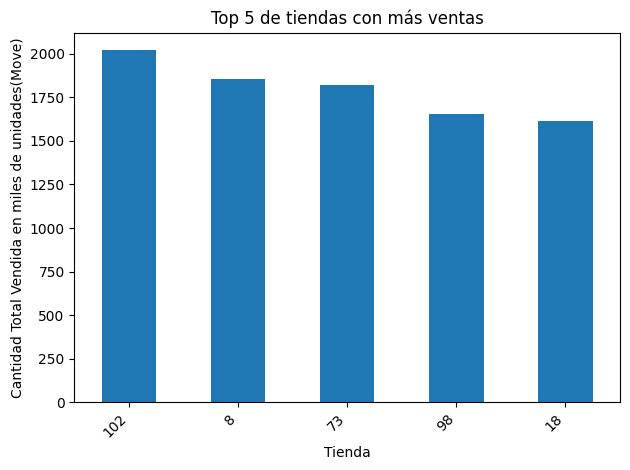

In [114]:
# Ventas (move) por tienda durante todo el periodo
ventas_por_tienda = df_move.groupby('store')['move'].sum().divide(1000).sort_values(ascending=False).head(5)
ventas_por_tienda.plot(kind='bar')
plt.title('Top 5 de tiendas con más ventas')
plt.xlabel('Tienda')
plt.ylabel('Cantidad Total Vendida en miles de unidades(Move)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

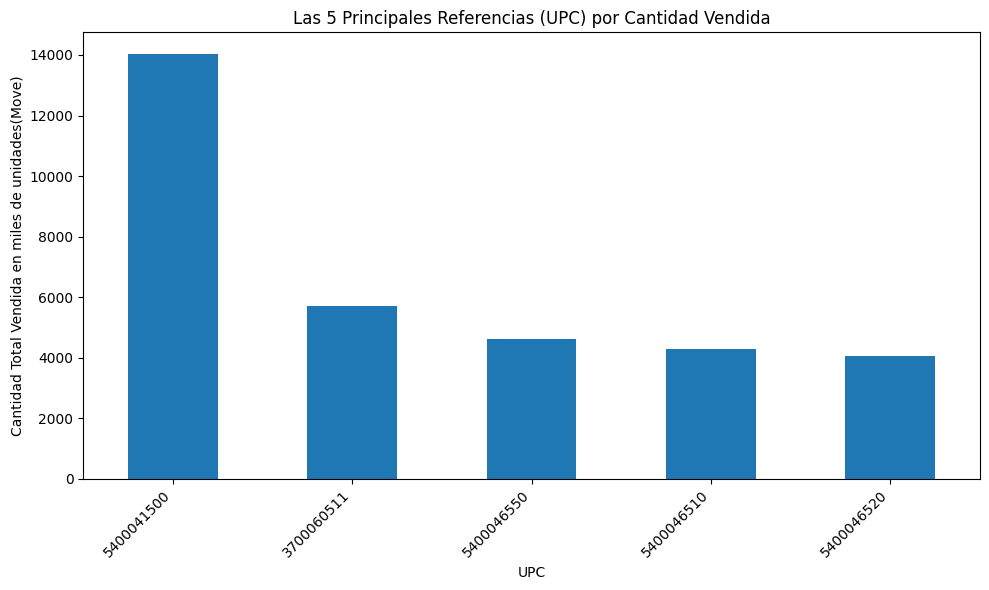

In [115]:
# 5 principales referencias (upc) que más se vendieron
ventas_por_upc = df_move.groupby('upc')['move'].sum().divide(1000).sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 6))
ventas_por_upc.plot(kind='bar')
plt.title('Las 5 Principales Referencias (UPC) por Cantidad Vendida')
plt.xlabel('UPC')
plt.ylabel('Cantidad Total Vendida en miles de unidades(Move)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

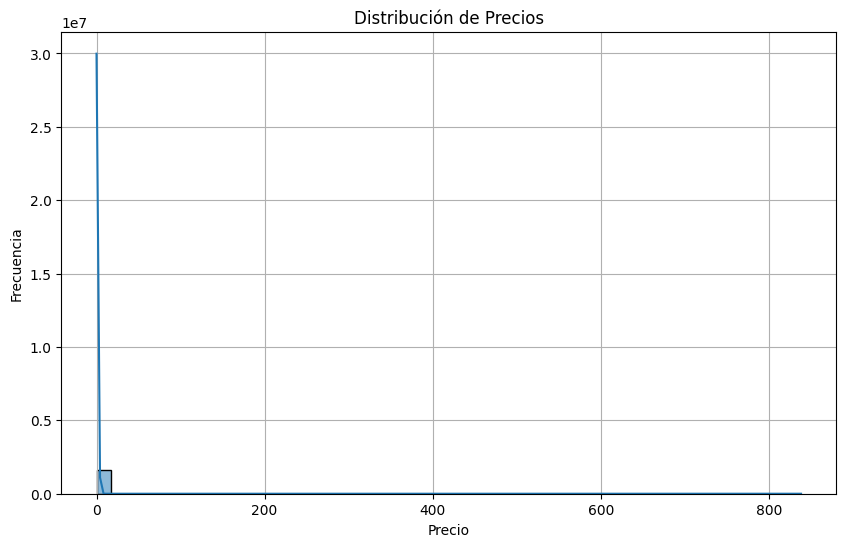

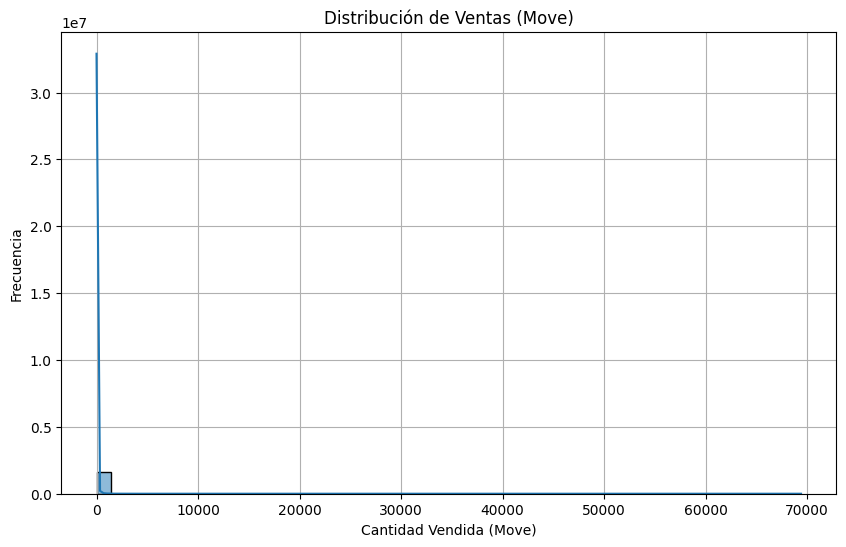

In [137]:
# Gráfico de distribución (histograma) para 'price'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='price', kde=True, bins=50) # kde=True añade una línea de densidad estimada
plt.title('Distribución de Precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de distribución (histograma) para 'move'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_merged, x='move', kde=True, bins=50) # puedes ajustar 'bins' según necesites
plt.title('Distribución de Ventas (Move)')
plt.xlabel('Cantidad Vendida (Move)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

### Limitaciones del dataset

Segun la documentación del dataset, es posible que haya algunos días donde no se haya marcado con S(reducción de precio) y tuviera reducción de precio.

##**Preparación del dataset**

Para la preparación de dataset se procederá con lo siguiente:
1. Identificación y tratamiento de datos nulos
2. Identificación y tratamiento de datos atipicos
3. Tranformaciones de los datos (Estandarización y creación de variables derivadas)
4. Integración de fuentes

###**1. Identificación y tratamiento de datos nulos**

In [123]:
print("Número de valores nulos por columna en df_merged:")
print(df_merged.isnull().sum())

Número de valores nulos por columna en df_merged:
store                    0
upc                      0
week                     0
move                     0
price                    0
qty                      0
sale               1396457
profit                   0
ok                       0
price_hex                0
profit_hex               0
com_code                 0
descrip                  0
size                     0
case                     0
nitem                    0
sale_calculated          0
dtype: int64


Se tienen varios datos vacios en la variable Sale que es la variable que identifica el tipo de promoción que se aplicó. Los valores que están vacios es porque se asume el precio estuvo sin ningun tipo de promoción, asi que definimos reemplazar este valor por una categoria: no_aplica, ya que no se le aplicó ningún descuento.

In [124]:
df_merged['sale'] = df_merged['sale'].fillna('no_aplica')
print(df_merged[['price', 'move', 'qty', 'sale']].head())

   price  move  qty       sale
0   0.00     0    1  no_aplica
1   0.00     0    1  no_aplica
2   2.09     1    1  no_aplica
3   2.09     4    1  no_aplica
4   2.09     7    1  no_aplica


In [125]:
print("Número de valores nulos por columna en df_merged:")
print(df_merged.isnull().sum())

Número de valores nulos por columna en df_merged:
store              0
upc                0
week               0
move               0
price              0
qty                0
sale               0
profit             0
ok                 0
price_hex          0
profit_hex         0
com_code           0
descrip            0
size               0
case               0
nitem              0
sale_calculated    0
dtype: int64


### **2. Identificación y tratamiento de datos atípicos**

In [136]:
# Identificar atípicos en 'price' usando IQR
Q1_price = df_merged['price'].quantile(0.25)
Q3_price = df_merged['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

limite_inferior_price = Q1_price - 1.5 * IQR_price
limite_superior_price = Q3_price + 1.5 * IQR_price

atipicos_price_iqr = df_merged[(df_merged['price'] < limite_inferior_price) | (df_merged['price'] > limite_superior_price)]
num_atipicos_price_iqr = df_merged[(df_merged['price'] < limite_inferior_price) | (df_merged['price'] > limite_superior_price)].shape[0]
print("Datos atípicos en 'price' (usando IQR):")
print(atipicos_price_iqr[['price', 'move', 'week', 'store']].head()) # Mostrar algunas columnas relevantes
print(f"Número de datos atípicos en 'price' (usando IQR): {num_atipicos_price_iqr}")
print(f"Porcentaje de datos atípicos en 'price' (usando IQR): {num_atipicos_price_iqr/len(df_merged)*100:.2f}%")


# Identificar atípicos en 'move' usando IQR
Q1_move = df_merged['move'].quantile(0.25)
Q3_move = df_merged['move'].quantile(0.75)
IQR_move = Q3_move - Q1_move

limite_inferior_move = Q1_move - 1.5 * IQR_move
limite_superior_move = Q3_move + 1.5 * IQR_move

atipicos_move_iqr = df_merged[(df_merged['move'] < limite_inferior_move) | (df_merged['move'] > limite_superior_move)]
num_atipicos_move_iqr = df_merged[(df_merged['move'] < limite_inferior_move) | (df_merged['move'] > limite_superior_move)].shape[0]

print("\nDatos atípicos en 'move' (usando IQR):")
print(atipicos_move_iqr[['price', 'move', 'week', 'store']].head()) # Mostrar algunas columnas relevantes
print(f"Número de datos atípicos en 'move' (usando IQR): {num_atipicos_move_iqr}")
print(f"Porcentaje de datos atípicos en 'move' (usando IQR): {num_atipicos_move_iqr/len(df_merged)*100:.2f}%")
print(len(df_merged))

Datos atípicos en 'price' (usando IQR):
       price  move  week  store
58954  11.99     3   386      2
58955  11.99    11   387      2
58956  11.99    11   388      2
58957  11.99     2   389      2
58958  11.99     1   390      2
Número de datos atípicos en 'price' (usando IQR): 63981
Porcentaje de datos atípicos en 'price' (usando IQR): 3.93%

Datos atípicos en 'move' (usando IQR):
      price  move  week  store
3661   2.09   113   357    130
4415   1.09   163    20      2
4419   1.19   192    24      2
4438   0.89   378    43      2
4443   1.29   627    48      2
Número de datos atípicos en 'move' (usando IQR): 158165
Porcentaje de datos atípicos en 'move' (usando IQR): 9.72%
1627284


In [138]:
# Eliminar los datos atípicos identificados
df_cleaned = df_merged[
    (df_merged['price'] >= limite_inferior_price) & (df_merged['price'] <= limite_superior_price) &
    (df_merged['move'] >= limite_inferior_move) & (df_merged['move'] <= limite_superior_move)
]

print("\nDimensiones del DataFrame después de eliminar atípicos:", df_cleaned.shape)


Dimensiones del DataFrame después de eliminar atípicos: (1405382, 17)


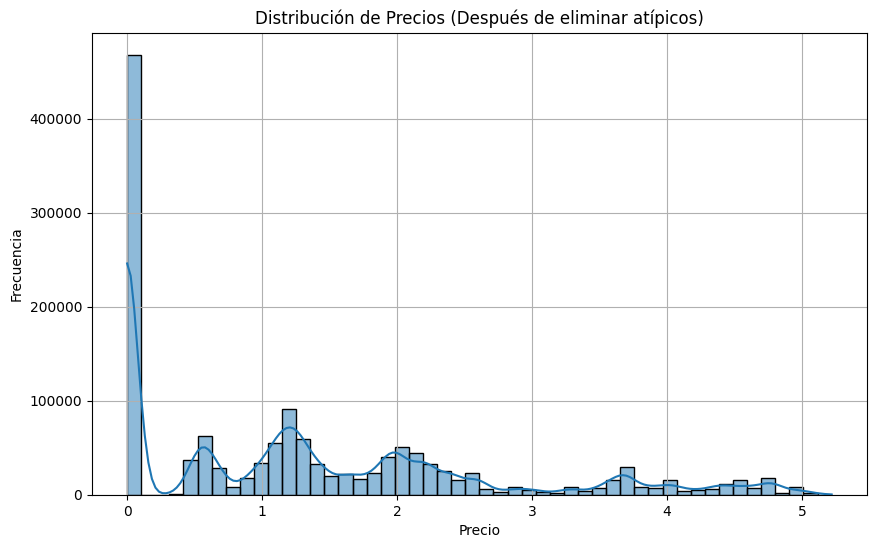

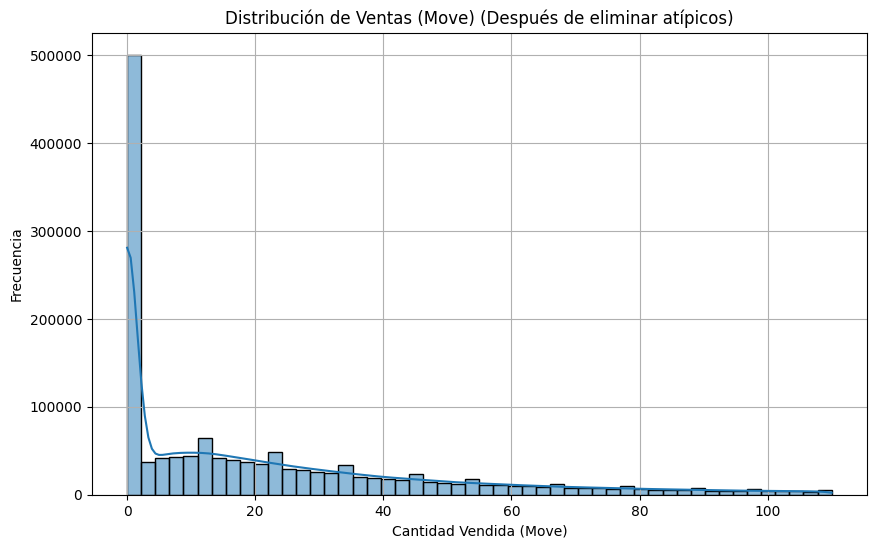

In [139]:
# Gráfico de distribución (histograma) para 'price' después de eliminar atípicos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='price', kde=True, bins=50)
plt.title('Distribución de Precios (Después de eliminar atípicos)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de distribución (histograma) para 'move' después de eliminar atípicos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='move', kde=True, bins=50)
plt.title('Distribución de Ventas (Move) (Después de eliminar atípicos)')
plt.xlabel('Cantidad Vendida (Move)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [140]:
# Calcular la frecuencia de cada precio en el DataFrame limpio
frecuencia_precios = df_cleaned['price'].value_counts()

# Obtener el precio con la frecuencia más alta
precio_mas_frecuente = frecuencia_precios.index[0]
frecuencia_maxima = frecuencia_precios.iloc[0]

print(f"El precio que más se repite es: {precio_mas_frecuente} con una frecuencia de: {frecuencia_maxima}")

El precio que más se repite es: 0.0 con una frecuencia de: 468231


In [141]:
# Eliminar filas donde el precio es 0 o la venta (move) es 0
df_cleaned = df_cleaned[(df_cleaned['price'] > 0) & (df_cleaned['move'] > 0)]

print("\nDimensiones del DataFrame después de eliminar precio 0 y venta 0:", df_cleaned.shape)


Dimensiones del DataFrame después de eliminar precio 0 y venta 0: (937151, 17)


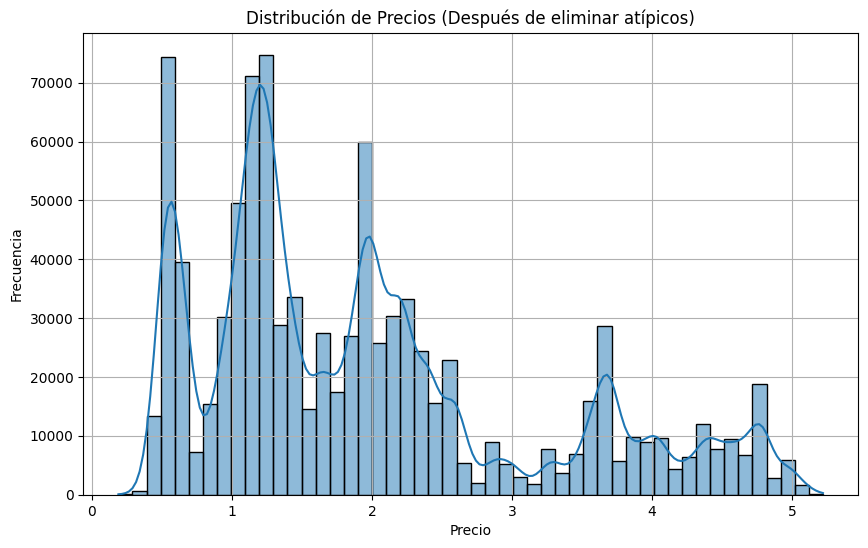

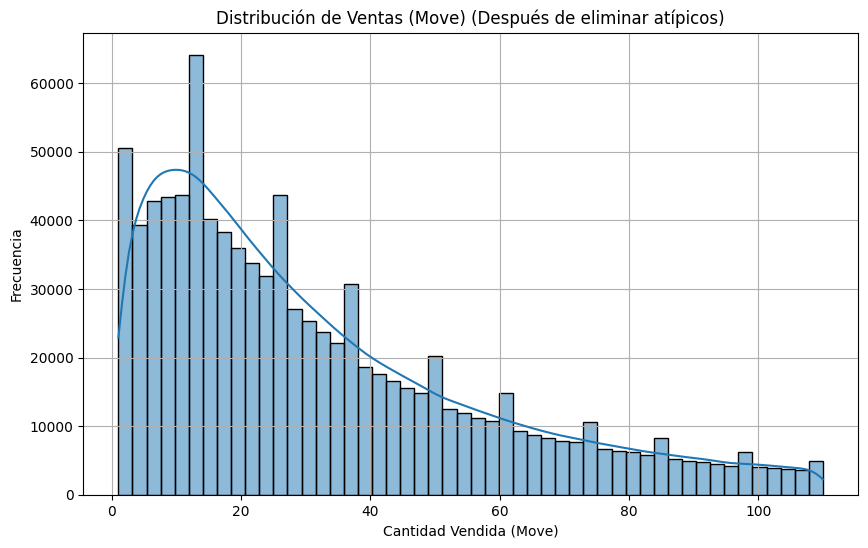

In [142]:
# Gráfico de distribución (histograma) para 'price' después de eliminar atípicos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='price', kde=True, bins=50)
plt.title('Distribución de Precios (Después de eliminar atípicos)')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

# Gráfico de distribución (histograma) para 'move' después de eliminar atípicos
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='move', kde=True, bins=50)
plt.title('Distribución de Ventas (Move) (Después de eliminar atípicos)')
plt.xlabel('Cantidad Vendida (Move)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

   move  log_move
2     1  0.000000
3     4  1.386294
4     7  1.945910
5     9  2.197225
6     3  1.098612


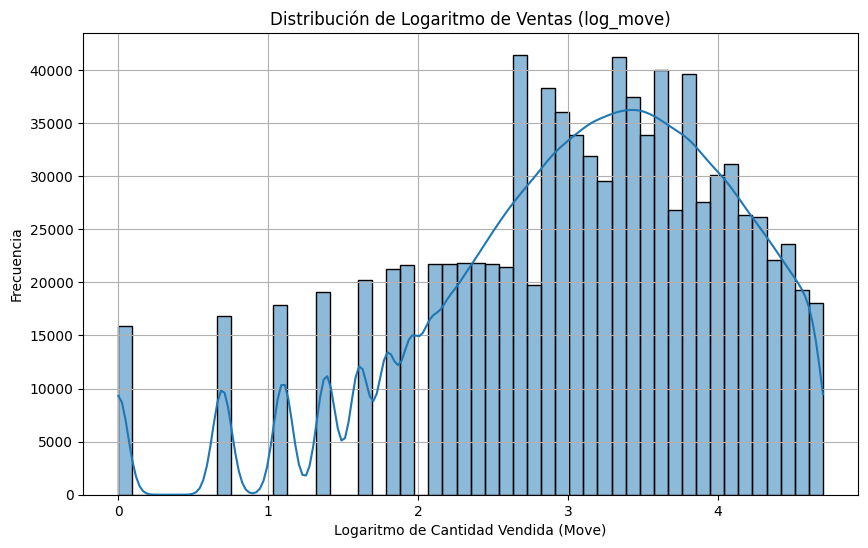

In [143]:
# Aplicar la transformación logarítmica a la columna 'move'
df_cleaned['log_move'] = np.log(df_cleaned['move'])

# Mostrar las primeras filas para verificar la nueva columna
print(df_cleaned[['move', 'log_move']].head())

# Gráfico de distribución (histograma) para 'log_move'
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cleaned, x='log_move', kde=True, bins=50)
plt.title('Distribución de Logaritmo de Ventas (log_move)')
plt.xlabel('Logaritmo de Cantidad Vendida (Move)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [147]:
# Calcular la correlación entre 'price' y 'move'
correlacion_precio_venta = df_cleaned['price'].corr(df_cleaned['move'])

print(f"La correlación entre Precio y Ventas (Move) es: {correlacion_precio_venta:.2f}")

La correlación entre Precio y Ventas (Move) es: -0.41


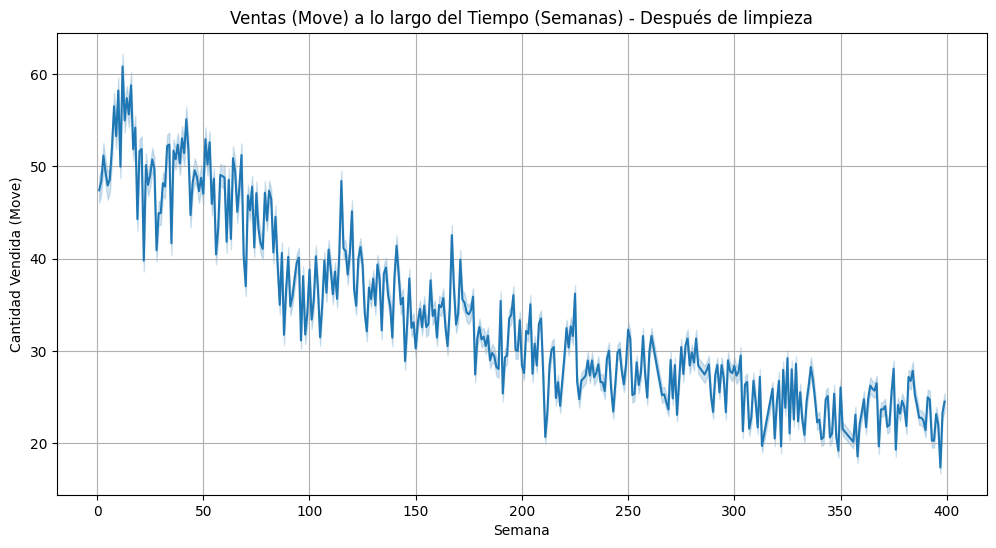

In [148]:
# move en y vs week en x
plt.figure(figsize=(12, 6))
sns.lineplot(x='week', y='move', data=df_cleaned)
plt.title('Ventas (Move) a lo largo del Tiempo (Semanas) - Después de limpieza')
plt.xlabel('Semana')
plt.ylabel('Cantidad Vendida (Move)')
plt.grid(True)
plt.show()

In [150]:
# Definir la fecha de inicio para la semana 1 (09/14/89)
fecha_inicio = pd.to_datetime('09/14/1989')

# Calcular la fecha de inicio de cada semana
# Restamos 1 a 'week' porque la semana 1 es la fecha de inicio
df_cleaned['start_of_week'] = fecha_inicio + pd.to_timedelta(df_cleaned['week'] - 1, unit='week')

# Mostrar las primeras filas con la nueva columna de fecha
print(df_cleaned[['week', 'start_of_week']].head())

ValueError: invalid unit abbreviation: week